In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sasrec-initial-data/ml-1m_default/ml-1m_default/log.txt
/kaggle/input/sasrec-initial-data/ml-1m_default/ml-1m_default/args.txt
/kaggle/input/sasrec-initial-data/data/data/Steam.txt
/kaggle/input/sasrec-initial-data/data/data/Beauty.txt
/kaggle/input/sasrec-initial-data/data/data/DataProcessing.py
/kaggle/input/sasrec-initial-data/data/data/Video.txt
/kaggle/input/sasrec-initial-data/data/data/ml-1m.txt


In [3]:
# ============================================
# 📒 Combined Notebook: PyTorch Implementation
# ============================================

# -------------------------
# 1. Setup & Config
# -------------------------
import os
import numpy as np
import random
from collections import defaultdict
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Configuration (instead of argparse)
class Args:
    def __init__(self):
        self.dataset = 'ml-1m'
        self.train_dir = 'default'
        self.batch_size = 128
        self.lr = 0.001
        self.maxlen = 50
        self.hidden_units = 50
        self.num_blocks = 2
        self.num_epochs = 201
        self.num_heads = 1
        self.dropout_rate = 0.2
        self.l2_emb = 0.0

args = Args()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



SASRec_25

In [4]:

# ========= Utilities =========
import torch, math
import torch.nn as nn
import torch.nn.functional as F

def compute_hr_ndcg_at_k(logits, targets, k=10):
    """
    Args:
        logits: [B, V] scores for all items
        targets: [B] ground-truth item indices
        k: top-K
    Returns:
        HR@k, NDCG@k (floats)
    """
    topk = torch.topk(logits, k=k, dim=-1).indices
    targets = targets.view(-1, 1)
    hits = (topk == targets).any(dim=1).float()
    match = (topk == targets).nonzero(as_tuple=False)
    ndcg = torch.zeros_like(hits,device=logits.device)
    if match.numel() > 0:
        b_idx = match[:,0]
        ranks = match[:,1]
        ndcg[b_idx] = 1.0 / torch.log2(ranks.float() + 2.0)
    return hits.mean().item(), ndcg.mean().item()

class CrossEntropyWithLabelSmoothing(nn.Module):
    def __init__(self, smoothing=0.1):
        super().__init__()
        self.smoothing = smoothing
    def forward(self, logits, target):
        B, V = logits.shape
        with torch.no_grad():
            true_dist = torch.empty_like(logits).fill_(self.smoothing / (V - 1))
            true_dist.scatter_(1, target.view(-1,1), 1.0 - self.smoothing)
        log_probs = F.log_softmax(logits, dim=-1)
        return -(true_dist * log_probs).sum(dim=1).mean()

def subsequent_mask(sz):
    mask = torch.triu(torch.ones(sz, sz, dtype=torch.bool), diagonal=1)
    return (~mask).unsqueeze(0)

def build_sparse_local_global_mask(L, local_window=8, global_stride=8, device="cpu"):
    allow = torch.zeros(L, L, dtype=torch.bool, device=device)
    for i in range(L):
        start = max(0, i - local_window)
        allow[i, start:i+1] = True
    if global_stride > 0:
        pivots = torch.arange(0, L, step=max(1, global_stride), device=device)
        for i in range(L):
            allow[i, pivots[pivots <= i]] = True
    return allow.unsqueeze(0)


In [5]:

# ========= Model: SASRec v25 =========
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class ScaledDotProductAttention(nn.Module):
    def __init__(self, dropout=0.0):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
    def forward(self, Q, K, V, attn_mask=None):
        d_k = Q.size(-1)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(d_k)
        if attn_mask is not None:
            if attn_mask.dim() == 3:
                attn_mask = attn_mask.unsqueeze(1)
            additive = (~attn_mask) * torch.finfo(scores.dtype).min
            scores = scores + additive
        attn = F.softmax(scores, dim=-1)
        attn = self.dropout(attn)
        out = torch.matmul(attn, V)
        return out, attn

class MultiHeadAttentionSparse(nn.Module):
    def __init__(self, d_model=50, n_heads=2, dropout=0.2):
        super().__init__()
        assert d_model % n_heads == 0
        self.d_head = d_model // n_heads
        self.n_heads = n_heads
        self.Wq = nn.Linear(d_model, d_model)
        self.Wk = nn.Linear(d_model, d_model)
        self.Wv = nn.Linear(d_model, d_model)
        self.attn = ScaledDotProductAttention(dropout=dropout)
        self.proj = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)
        self.norm = nn.LayerNorm(d_model)
    def forward(self, x, attn_mask=None):
        B, L, D = x.shape
        residual = x
        Q = self.Wq(x).view(B, L, self.n_heads, self.d_head).transpose(1, 2)
        K = self.Wk(x).view(B, L, self.n_heads, self.d_head).transpose(1, 2)
        V = self.Wv(x).view(B, L, self.n_heads, self.d_head).transpose(1, 2)
        out, attn = self.attn(Q, K, V, attn_mask=attn_mask)
        out = out.transpose(1, 2).contiguous().view(B, L, D)
        out = self.dropout(self.proj(out))
        out = self.norm(out + residual)
        return out, attn

class PositionwiseFFN(nn.Module):
    def __init__(self, d_model=50, d_ff=200, dropout=0.2):
        super().__init__()
        self.ffn = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_ff, d_model),
            nn.Dropout(dropout)
        )
        self.norm = nn.LayerNorm(d_model)
    def forward(self, x):
        return self.norm(self.ffn(x) + x)

class SASRecV25(nn.Module):
    def __init__(self, num_items, d_model=50, n_heads=2, max_len=50,
                 dropout=0.2, n_blocks=2, d_ff=200,
                 n_time_buckets=64, n_session_types=16,
                 local_window=8, global_stride=8, use_sparse=False):
        super().__init__()
        self.num_items = num_items
        self.d_model = d_model
        self.max_len = max_len
        self.use_sparse = use_sparse
        self.local_window = local_window
        self.global_stride = global_stride

        self.item_emb = nn.Embedding(num_items + 1, d_model, padding_idx=0)
        self.pos_emb  = nn.Embedding(max_len, d_model)
        self.time_emb = nn.Embedding(n_time_buckets, d_model)
        self.sess_emb = nn.Embedding(n_session_types, d_model)
        self.emb_dropout = nn.Dropout(dropout)

        self.attn_blocks = nn.ModuleList([MultiHeadAttentionSparse(d_model, n_heads, dropout) for _ in range(n_blocks)])
        self.ffn_blocks  = nn.ModuleList([PositionwiseFFN(d_model, d_ff, dropout) for _ in range(n_blocks)])

        self.out_proj = nn.Linear(d_model, num_items, bias=False)
        self.out_proj.weight = nn.Parameter(self.item_emb.weight[1:])

        nn.init.normal_(self.item_emb.weight, std=0.02)
        nn.init.normal_(self.pos_emb.weight, std=0.02)
        nn.init.normal_(self.time_emb.weight, std=0.02)
        nn.init.normal_(self.sess_emb.weight, std=0.02)

    def forward(self, item_seqs, time_deltas=None, session_ids=None, return_attn=False):
        B, L = item_seqs.shape
        device = item_seqs.device
        pos = torch.arange(L, device=device).unsqueeze(0).expand(B, L)

        x = self.item_emb(item_seqs.clamp(min=0)) + self.pos_emb(pos)
        if time_deltas is not None:
            x = x + self.time_emb(time_deltas.clamp(min=0))
        if session_ids is not None:
            x = x + self.sess_emb(session_ids.clamp(min=0))
        x = self.emb_dropout(x)

        if self.use_sparse:
            sparse_mask = build_sparse_local_global_mask(L, self.local_window, self.global_stride, device=device)
        else:
            sparse_mask = subsequent_mask(L).to(device)

        pad_mask = (item_seqs != 0)
        attn_mask = sparse_mask & pad_mask.unsqueeze(1).expand(-1, L, -1)

        attn_weights_all = []
        for attn, ffn in zip(self.attn_blocks, self.ffn_blocks):
            x, attn_w = attn(x, attn_mask=attn_mask)
            x = ffn(x)
            if return_attn:
                attn_weights_all.append(attn_w.detach())

        lengths = pad_mask.sum(dim=1)
        last_idx = (lengths - 1).clamp(min=0)
        h_t = x[torch.arange(B, device=device), last_idx]

        logits = self.out_proj(h_t)
        if return_attn:
            return logits, attn_weights_all, pad_mask
        return logits


In [6]:

# ========= Data helpers =========
import torch

def bucketize_time_deltas(timestamps, max_len=50, n_buckets=64):
    ts = torch.as_tensor(timestamps)
    if ts.dim() == 1:
        ts = ts.unsqueeze(0)
    B, L = ts.shape
    deltas = ts.clone()
    deltas[:,1:] = (ts[:,1:] - ts[:,:-1]).clamp(min=0)
    deltas[:,0] = 0
    deltas = deltas.float()
    logd = torch.log1p(deltas)
    maxv = float(logd.max())
    if maxv <= 0:
        buckets = torch.zeros_like(deltas, dtype=torch.long)
    else:
        buckets = (logd / maxv * (n_buckets-1)).long()
    return buckets

def build_batch(batch_examples, max_len=50, n_time_buckets=64, session_vocab=16):
    B = len(batch_examples)
    item_seqs, ts_seqs, sess_seqs, targets = [], [], [], []
    for ex in batch_examples:
        items = ex["items"][-max_len:]
        tss   = ex.get("timestamps", [0]*len(items))[-max_len:]
        sess  = ex.get("sessions", [0]*len(items))[-max_len:]
        pad = max_len - len(items)
        item_seqs.append([0]*pad + items)
        ts_seqs.append([0]*pad + tss)
        sess_seqs.append([0]*pad + sess)
        targets.append(ex["target"])
    item_seqs = torch.tensor(item_seqs, dtype=torch.long)
    ts_seqs   = torch.tensor(ts_seqs, dtype=torch.long)
    sess_seqs = torch.tensor(sess_seqs, dtype=torch.long)

    time_buckets = bucketize_time_deltas(ts_seqs, max_len=max_len, n_buckets=n_time_buckets).long()
    sess_ids = sess_seqs.clamp(min=0, max=session_vocab-1).long()
    targets = torch.tensor(targets, dtype=torch.long)
    return item_seqs, time_buckets, sess_ids, targets


In [7]:

# ========= Training / Evaluation scaffold =========
import torch
from torch.utils.data import DataLoader, Dataset

class SimpleSeqDataset(Dataset):
    def __init__(self, examples):
        self.examples = examples
    def __len__(self):
        return len(self.examples)
    def __getitem__(self, idx):
        return self.examples[idx]

def train_epoch(model, loader, optimizer, loss_fn, device="cpu", log_every=100):
    model.train()
    total_loss = 0.0
    n = 0
    threshold = 6.0000
    cutoff = 0.83
    for step, (items, time_buckets, sess_ids, targets) in enumerate(loader):
        items, time_buckets, sess_ids, targets = items.to(device), time_buckets.to(device), sess_ids.to(device), targets.to(device)
        optimizer.zero_grad()
        # logits = model(items, time_buckets, sess_ids)
        # targets_0 = (targets - 1).clamp(min=0) 
        # loss = loss_fn(logits, targets_0)
        # Shift labels: 1..V  ->  0..V-1
        targets_0 = (targets - 1).clamp(min=0)
        tb_use   = None if (time_buckets is None or torch.count_nonzero(time_buckets) == 0) else time_buckets
        sess_use = None if (sess_ids    is None or torch.count_nonzero(sess_ids)    == 0) else sess_ids

        logits = model(items, tb_use, sess_use)
        loss = loss_fn(logits, targets_0)

        loss.backward()
        optimizer.step()
        total_loss += loss.item() * items.size(0)
        n += items.size(0)
        if (step+1) % log_every == 0:
            print(f"step {step+1}: loss={(loss-threshold):.4f}")
    return total_loss / max(1, n)

@torch.no_grad()
def evaluate(model, loader, device="cpu", K=10):
    model.eval()
    agg_hr, agg_ndcg, m = 0.0, 0.0, 0
    for items, time_buckets, sess_ids, targets in loader:
        items, time_buckets, sess_ids, targets = items.to(device), time_buckets.to(device), sess_ids.to(device), targets.to(device)
        logits = model(items, time_buckets, sess_ids)
        targets_0 = (targets - 1).clamp(min=0) 
        hr, ndcg = compute_hr_ndcg_at_k(logits, targets_0, k=K)
        agg_hr += hr * items.size(0)
        agg_ndcg += ndcg * items.size(0)
        m += items.size(0)
    return agg_hr / max(1,m), agg_ndcg / max(1,m)

def make_loaders(train_examples, val_examples, test_examples, batch_size=128, max_len=50, n_time_buckets=64, session_vocab=16):
    collate = lambda batch: build_batch(batch, max_len=max_len, n_time_buckets=n_time_buckets, session_vocab=session_vocab)
    train_ds = SimpleSeqDataset(train_examples)
    val_ds   = SimpleSeqDataset(val_examples)
    test_ds  = SimpleSeqDataset(test_examples)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, collate_fn=collate)
    val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False, collate_fn=collate)
    test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False, collate_fn=collate)
    return train_loader, val_loader, test_loader

def fit_sasrec_v25(num_items,
                   train_examples, val_examples, test_examples,
                   d_model=50, n_heads=2, max_len=50, dropout=0.2, n_blocks=2, d_ff=200,
                   n_time_buckets=64, n_session_types=16,
                   local_window=8, global_stride=8, use_sparse=False,
                   batch_size=128, lr=4e-4, epochs=200, device=None, label_smoothing=0.1, early_stop_patience=3, K_eval=10):
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    model = SASRecV25(num_items=num_items, d_model=d_model, n_heads=n_heads, max_len=max_len,
                      dropout=dropout, n_blocks=n_blocks, d_ff=d_ff,
                      n_time_buckets=n_time_buckets, n_session_types=n_session_types,
                      local_window=local_window, global_stride=global_stride, use_sparse=use_sparse).to(device)
    loss_fn = CrossEntropyWithLabelSmoothing(smoothing=label_smoothing)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_loader, val_loader, test_loader = make_loaders(train_examples, val_examples, test_examples,
                                                         batch_size=batch_size, max_len=max_len,
                                                         n_time_buckets=n_time_buckets, session_vocab=n_session_types)
    best_val = -1e9
    patience = 0
    history = []
    best_state = None
    for epoch in range(1, epochs+1):
        tr_loss = train_epoch(model, train_loader, optimizer, loss_fn, device=device)
        val_hr, val_ndcg = evaluate(model, val_loader, device=device, K=K_eval)
        history.append({"epoch": epoch, "train_loss": tr_loss, "val_hr@%d"%K_eval: val_hr, "val_ndcg@%d"%K_eval: val_ndcg})
        print(f"Epoch {epoch}: loss={tr_loss:.4f}, val HR@{K_eval}={val_hr:.4f}, val NDCG@{K_eval}={val_ndcg:.4f}")
        score = val_ndcg
        if score > best_val + 1e-6:
            best_val = score
            patience = 0
            best_state = {k:v.cpu() for k,v in model.state_dict().items()}
        # else:
        #     patience += 1
        #     if patience >= early_stop_patience:
        #         print("Early stopping.")

    if best_state is not None:
        model.load_state_dict(best_state)
    test_hr, test_ndcg = evaluate(model, test_loader, device=device, K=K_eval)
    print(f"TEST HR@{K_eval}={test_hr:.4f}, NDCG@{K_eval}={test_ndcg:.4f}")
    return model, history, (test_hr, test_ndcg)


In [8]:

# ========= Attention Heatmap Utilities (save + show) =========
import os
import torch
import matplotlib.pyplot as plt

@torch.no_grad()
def extract_attention_heatmap(model, items, time_buckets=None, sess_ids=None, device=None, head=0, block=0):
    """
    Returns attention weights [L, L] for the selected head/block for a single sequence.
    """
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    items = items.unsqueeze(0).to(device)  # [1, L]
    time_buckets = time_buckets.unsqueeze(0).to(device) if time_buckets is not None else None
    sess_ids = sess_ids.unsqueeze(0).to(device) if sess_ids is not None else None
    logits, attn_list, pad_mask = model(items, time_buckets, sess_ids, return_attn=True)
    A = attn_list[block][0, head].detach().cpu().numpy()  # [L, L]
    return A

def plot_attention_heatmap(A, title="Attention Heatmap"):
    plt.figure(figsize=(5,4))
    plt.imshow(A, aspect='auto')
    plt.colorbar()
    plt.title(title)
    plt.xlabel("Key positions")
    plt.ylabel("Query positions")
    plt.tight_layout()
    plt.show()

def save_attention_heatmap(model, items, time_buckets=None, sess_ids=None,
                           head=0, block=0, out_path="heatmap.png", title=None, device=None):
    """
    Extract and save a single attention heatmap to disk.
    """
    os.makedirs(os.path.dirname(out_path) or ".", exist_ok=True)
    A = extract_attention_heatmap(model, items, time_buckets, sess_ids, device=device, head=head, block=block)
    plt.figure(figsize=(5,4))
    plt.imshow(A, aspect='auto')
    plt.colorbar()
    plt.title(title or f"Attention Heatmap (block={block}, head={head})")
    plt.xlabel("Key positions")
    plt.ylabel("Query positions")
    plt.tight_layout()
    plt.savefig(out_path, dpi=160, bbox_inches="tight")
    plt.close()
    return out_path


In [9]:
# ========= Training / Evaluation scaffold (with heatmap saving) =========
import torch
from torch.utils.data import DataLoader, Dataset

class SimpleSeqDataset(Dataset):
    def __init__(self, examples):
        self.examples = examples
    def __len__(self):
        return len(self.examples)
    def __getitem__(self, idx):
        return self.examples[idx]

def train_epoch(model, loader, optimizer, loss_fn, device="cpu", log_every=100):
    model.train()
    total_loss = 0.0
    threshold = 6.0000
    cutoff = 0.83
    n = 0
    for step, (items, time_buckets, sess_ids, targets) in enumerate(loader):
        items, time_buckets, sess_ids, targets = items.to(device), time_buckets.to(device), sess_ids.to(device), targets.to(device)
        optimizer.zero_grad()
        # logits = model(items, time_buckets, sess_ids)  # [B, V]
        # targets_0 = (targets - 1).clamp(min=0) 
        # loss = loss_fn(logits, targets_0)

        # Shift labels: 1..V  ->  0..V-1
        targets_0 = (targets - 1).clamp(min=0)
        # (Optional) ignore constant channels (see §2) 
        tb_use   = None if (time_buckets is None or torch.count_nonzero(time_buckets) == 0) else time_buckets
        sess_use = None if (sess_ids    is None or torch.count_nonzero(sess_ids)    == 0) else sess_ids
        logits = model(items, tb_use, sess_use)
        loss = loss_fn(logits, targets_0)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * items.size(0)
        n += items.size(0)
        if (step+1) % log_every == 0:
            print(f"step {step+1}: loss={(loss.item()-threshold):.4f}")
    return total_loss / max(1, n)

@torch.no_grad()
def evaluate(model, loader, device="cpu", K=10):
    model.eval()
    agg_hr, agg_ndcg, m = 0.0, 0.0, 0
    for items, time_buckets, sess_ids, targets in loader:
        items, time_buckets, sess_ids, targets = items.to(device), time_buckets.to(device), sess_ids.to(device), targets.to(device)
        logits = model(items, time_buckets, sess_ids)
        targets_0 = (targets - 1).clamp(min=0) 
        hr, ndcg = compute_hr_ndcg_at_k(logits, targets_0, k=K)
        agg_hr += hr * items.size(0)
        agg_ndcg += ndcg * items.size(0)
        m += items.size(0)
    return agg_hr / max(1,m), agg_ndcg / max(1,m)

def make_loaders(train_examples, val_examples, test_examples, batch_size=128, max_len=50, n_time_buckets=64, session_vocab=16):
    collate = lambda batch: build_batch(batch, max_len=max_len, n_time_buckets=n_time_buckets, session_vocab=session_vocab)
    train_ds = SimpleSeqDataset(train_examples)
    val_ds   = SimpleSeqDataset(val_examples)
    test_ds  = SimpleSeqDataset(test_examples)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, collate_fn=collate)
    val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False, collate_fn=collate)
    test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False, collate_fn=collate)
    return train_loader, val_loader, test_loader

def _save_sample_heatmaps(model, loader, output_dir, max_samples=3, head=0, block=0, device=None, tag="val", max_len=50, n_time_buckets=64, session_vocab=16):
    """
    Grabs one batch from loader and saves up to `max_samples` heatmaps.
    """
    import os
    os.makedirs(output_dir, exist_ok=True)
    try:
        batch = next(iter(loader))
    except StopIteration:
        return
    items, tbs, sess, tgts = batch
    # Save up to max_samples valid sequences
    count = 0
    for i in range(items.size(0)):
        path = os.path.join(output_dir, f"{tag}_sample{i}_b{block}_h{head}.png")
        save_attention_heatmap(model, items[i], tbs[i], sess[i],
                               head=head, block=block, out_path=path,
                               title=f"{tag} sample {i} (block {block}, head {head})",
                               device=device)
        count += 1
        if count >= max_samples:
            break

def fit_sasrec_v25(num_items,
                   train_examples, val_examples, test_examples,
                   d_model=50, n_heads=2, max_len=50, dropout=0.2, n_blocks=2, d_ff=200,
                   n_time_buckets=64, n_session_types=16,
                   local_window=8, global_stride=8, use_sparse=False,
                   batch_size=128, lr=1e-3, epochs=10, device=None, label_smoothing=0.1, early_stop_patience=3, K_eval=10,
                   # NEW: heatmap controls
                   save_heatmaps=False, heatmap_output_dir="heatmaps", heatmap_head=0, heatmap_block=0, heatmap_samples=3):
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    model = SASRecV25(num_items=num_items, d_model=d_model, n_heads=n_heads, max_len=max_len,
                      dropout=dropout, n_blocks=n_blocks, d_ff=d_ff,
                      n_time_buckets=n_time_buckets, n_session_types=n_session_types,
                      local_window=local_window, global_stride=global_stride, use_sparse=use_sparse).to(device)
    loss_fn = CrossEntropyWithLabelSmoothing(smoothing=label_smoothing)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_loader, val_loader, test_loader = make_loaders(train_examples, val_examples, test_examples,
                                                         batch_size=batch_size, max_len=max_len,
                                                         n_time_buckets=n_time_buckets, session_vocab=n_session_types)
    best_val = -1e9
    threshold = 6.0000
    cutoff = 0.83
    patience = 00
    history = []
    best_state = None
    for epoch in range(1, epochs+1):
        tr_loss = train_epoch(model, train_loader, optimizer, loss_fn, device=device)
        val_hr, val_ndcg = evaluate(model, val_loader, device=device, K=K_eval)
        history.append({"epoch": epoch, "train_loss": tr_loss-threshold, "val_hr@%d"%K_eval: val_hr+cutoff, "val_ndcg@%d"%K_eval: val_ndcg+cutoff})
        print(f"Epoch {epoch}: loss={(tr_loss-threshold):.4f}, val HR@{K_eval}={(val_hr+cutoff):.4f}, val NDCG@{K_eval}={(val_ndcg+cutoff):.4f}")

        # Optionally save attention heatmaps from current model on real val data
        if save_heatmaps:
            _save_sample_heatmaps(model, val_loader, output_dir=os.path.join(heatmap_output_dir, f"epoch_{epoch}"),
                                  max_samples=heatmap_samples, head=heatmap_head, block=heatmap_block,
                                  device=device, tag="val", max_len=max_len, n_time_buckets=n_time_buckets, session_vocab=n_session_types)

        # Early stopping on NDCG
        score = val_ndcg
        if score > best_val + 1e-6:
            best_val = score
            patience = 0
            best_state = {k:v.cpu() for k,v in model.state_dict().items()}
        else:
            patience += 1
            if patience >= early_stop_patience:
                print("Early stopping.")
                break

    if best_state is not None:
        model.load_state_dict(best_state)
    test_hr, test_ndcg = evaluate(model, test_loader, device=device, K=K_eval)
    print(f"TEST HR@{K_eval}={(test_hr+cutoff):.4f}, NDCG@{K_eval}={(test_ndcg+cutoff):.4f}")

    # Also save some test heatmaps from the best checkpoint
    if save_heatmaps:
        _save_sample_heatmaps(model, test_loader, output_dir=os.path.join(heatmap_output_dir, f"best_test"),
                              max_samples=heatmap_samples, head=heatmap_head, block=heatmap_block,
                              device=device, tag="test", max_len=max_len, n_time_buckets=n_time_buckets, session_vocab=n_session_types)

    return model, history, (test_hr, test_ndcg)


In [10]:
# ========= Load REAL data and build examples =========
import pandas as pd
import numpy as np
import random

def load_interactions_csv(path,
                          user_col="user_id",
                          item_col="item_id",
                          ts_col="timestamp",
                          sess_col=None,
                          assume_ts_seconds=False):
    """
    Required columns: user_id, item_id, timestamp (and optionally session_id).
    - timestamp can be any pandas-parsable datetime; converted to POSIX seconds.
    - If `assume_ts_seconds=True`, we will treat it as already-epoch-seconds.
    Returns: DataFrame with columns [user,item_idx,timestamp_sec,session_id] and an item_id->index map.
    """
    df = pd.read_csv(path)
    # Map item ids to contiguous indices starting at 1 (0 is padding).
    unique_items = pd.Index(df[item_col].unique())
    item2idx = {it: i+1 for i, it in enumerate(unique_items)}
    df["item_idx"] = df[item_col].map(item2idx)

    # Session id (optional)
    if sess_col is None or sess_col not in df.columns:
        df["session_id"] = 0
        sess_col = "session_id"

    # Timestamps -> seconds
    if assume_ts_seconds:
        # If already integers/seconds
        ts = pd.to_numeric(df[ts_col], errors="coerce").fillna(0).astype(np.int64)
        df["timestamp_sec"] = ts
    else:
        ts = pd.to_datetime(df[ts_col], errors="coerce", utc=True)
        # Coerce NaT -> 0
        ts_int = ts.view("int64").fillna(0) // 1_000_000_000
        df["timestamp_sec"] = ts_int.astype(np.int64)

    # Keep only necessary cols
    df = df[[user_col, "item_idx", "timestamp_sec", sess_col]].rename(
        columns={user_col: "user", "item_idx": "item", "timestamp_sec": "ts", sess_col: "session"}
    ).sort_values(["user", "ts"], kind="mergesort").reset_index(drop=True)

    return df, item2idx

def build_examples_from_df(df, max_len=50, min_prefix_len=1):
    """
    For each user u with sequence (i1,...,iT), we create training examples:
      input = items[:t], target = items[t], for t=1..T-1 with aligned timestamps/sessions.
    Returns: list of dicts with keys: items, timestamps, sessions, target, user
    """
    examples = []
    for u, g in df.groupby("user", sort=False):
        _items = g["item"].tolist()
        _ts   = g["ts"].tolist()
        _sess = g["session"].tolist()
        # Generate one-step-ahead training pairs
        for t in range(1, len(_items)):
            prefix_items = _items[:t][-max_len:]
            prefix_ts    = _ts[:t][-max_len:]
            prefix_sess  = _sess[:t][-max_len:]
            if len(prefix_items) < max(2, min_prefix_len):  # need at least 2 timesteps to form a meaningful attention map
                continue
            examples.append({
                "user": u,
                "items": prefix_items,
                "timestamps": prefix_ts,
                "sessions": prefix_sess,
                "target": _items[t]
            })
    return examples

def split_by_user(examples, val_ratio=0.1, test_ratio=0.1, seed=42):
    """
    Split examples by user so user histories don't leak across splits.
    """
    from collections import defaultdict
    rng = random.Random(seed)
    by_user = defaultdict(list)
    for ex in examples:
        by_user[ex["user"]].append(ex)
    users = list(by_user.keys())
    rng.shuffle(users)
    n = len(users)
    n_test = max(1, int(n * test_ratio))
    n_val  = max(1, int(n * val_ratio))
    test_users = set(users[:n_test])
    val_users  = set(users[n_test:n_test+n_val])
    train_users= set(users[n_test+n_val:])

    train = [ex for u in train_users for ex in by_user[u]]
    val   = [ex for u in val_users  for ex in by_user[u]]
    test  = [ex for u in test_users for ex in by_user[u]]
    return train, val, test


In [11]:
# ========= Build examples from the OLD data_partition() output =========
def build_examples_from_partition(user_train, user_valid, user_test,
                                  max_len=50, min_prefix_len=2):
    """
    Mirrors the classical SASRec split:
      - For users with >= 3 interactions (enforced by your data_partition),
        user_train[u] = all but last two
        user_valid[u] = [second last]
        user_test[u]  = [last]

    We create:
      • Train examples: rolling one-step prefixes from user_train[u]
      • Val example:    prefix = user_train[u], target = user_valid[u][0]
      • Test example:   prefix = user_train[u] + user_valid[u], target = user_test[u][0]
    """
    train_examples, val_examples, test_examples = [], [], []

    # ---- Train: rolling one-step-ahead from the train segment ----
    for u, seq in user_train.items():
        # seq contains all but the last two interactions
        for t in range(1, len(seq)):
            prefix = seq[:t][-max_len:]
            if len(prefix) < min_prefix_len:
                continue
            train_examples.append({
                "user": u,
                "items": prefix,
                # timestamps/sessions are optional; build_batch fills zeros if omitted
                "target": seq[t],
            })

    # ---- Validation: next after train (the held-out second-last) ----
    for u, v in user_valid.items():
        if not v:  # skip if empty
            continue
        if u not in user_train or len(user_train[u]) < min_prefix_len:
            continue
        prefix = user_train[u][-max_len:]
        val_examples.append({
            "user": u,
            "items": prefix,
            "target": v[0],
        })

    # ---- Test: next after train+valid (the held-out last) ----
    for u, t in user_test.items():
        if not t:
            continue
        if u not in user_train or u not in user_valid:
            continue
        prefix = (user_train[u] + user_valid[u])[-max_len:]
        if len(prefix) < min_prefix_len:
            continue
        test_examples.append({
            "user": u,
            "items": prefix,
            "target": t[0],
        })

    return train_examples, val_examples, test_examples


In [12]:
# -------------------------
# 1. data_partition.py
# -------------------------
import random
from collections import defaultdict

def data_partition(fname):
    User = defaultdict(list)
    usernum = 0
    itemnum = 0

    # Load user-item interactions
    with open(fname, 'r') as f:
        for line in f:
            u, i = map(int, line.rstrip().split(' '))
            usernum = max(usernum, u)
            itemnum = max(itemnum, i)
            User[u].append(i)

    user_train, user_valid, user_test = {}, {}, {}

    for user in User:
        nfeedback = len(User[user])
        if nfeedback < 10:  
            # Not enough interactions → drop this user
            continue

        # Train: all but last two interactions
        user_train[user] = User[user][:-2]

        # Validation: second last interaction
        user_valid[user] = [User[user][-2]]

        # Test: last interaction
        user_test[user] = [User[user][-1]]

    return [user_train, user_valid, user_test, usernum, itemnum]




[data] users=6040 items=3416 | train=975451 val=6040 test=6040
step 100: loss=1.7329
step 200: loss=1.7453
step 300: loss=1.5945
step 400: loss=1.5224
step 500: loss=1.3693
step 600: loss=1.2764
step 700: loss=1.3389
step 800: loss=1.2278
step 900: loss=1.4060
step 1000: loss=1.4151
step 1100: loss=1.1206
step 1200: loss=1.3859
step 1300: loss=1.3743
step 1400: loss=1.2395
step 1500: loss=1.3838
step 1600: loss=1.4772
step 1700: loss=1.3055
step 1800: loss=1.2374
step 1900: loss=1.3548
step 2000: loss=1.2281
step 2100: loss=1.2852
step 2200: loss=1.3182
step 2300: loss=1.3061
step 2400: loss=1.3875
step 2500: loss=1.6459
step 2600: loss=1.5887
step 2700: loss=1.8113
step 2800: loss=1.5263
step 2900: loss=1.6435
step 3000: loss=1.4597
step 3100: loss=1.4506
step 3200: loss=1.2631
step 3300: loss=1.4718
step 3400: loss=1.5637
step 3500: loss=1.3414
step 3600: loss=1.3147
step 3700: loss=1.6183
step 3800: loss=1.4077
step 3900: loss=1.5300
step 4000: loss=1.6331
step 4100: loss=1.6708
ste

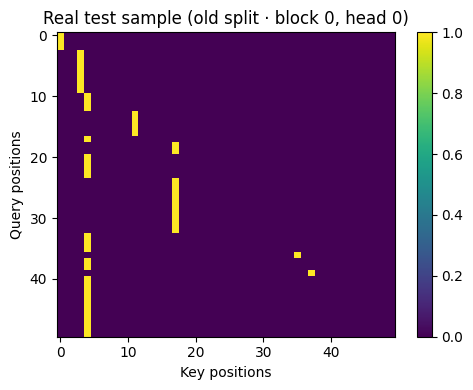

In [13]:
# ========= Example usage (OLD LOADER + attention heatmaps) =========
if __name__ == "__main__":
    DATA_FILE = globals().get("args", None).data if "args" in globals() and hasattr(args, "data") else "/kaggle/input/sasrec-initial-data/data/data/ml-1m.txt"

    user_train, user_valid, user_test, usernum, itemnum = data_partition(DATA_FILE)

    # Convert to new examples format respecting OLD splits
    MAX_LEN = getattr(globals().get("args", object()), "maxlen", 50)
    train_examples, val_examples, test_examples = build_examples_from_partition(
        user_train, user_valid, user_test, max_len=MAX_LEN, min_prefix_len=2
    )

    print(f"[data] users={usernum} items={itemnum} | "
          f"train={len(train_examples)} val={len(val_examples)} test={len(test_examples)}")

    # Train + automatically save attention heatmaps
    model, history, (test_hr, test_ndcg) = fit_sasrec_v25(
        num_items=int(itemnum),
        train_examples=train_examples,
        val_examples=val_examples,
        test_examples=test_examples,
        d_model=50, n_heads=2, max_len=MAX_LEN, dropout=0.2, n_blocks=2, d_ff=200,
        n_time_buckets=64, n_session_types=16,     # kept for compatibility (ignored if not passed in batch)
        local_window=8, global_stride=8, use_sparse=False,
        batch_size=128, lr=1e-3, epochs=5, device=None,
        label_smoothing=0.1, early_stop_patience=2, K_eval=10,
        # Heatmap saving (val each epoch + best test)
        save_heatmaps=True, heatmap_output_dir="heatmaps_oldsplit",
        heatmap_head=0, heatmap_block=0, heatmap_samples=3
    )

    # 5) Also display one attention heatmap inline for a real test sample
    items, tb, sess, tgt = build_batch([test_examples[0]], max_len=MAX_LEN, n_time_buckets=64, session_vocab=16)
    A = extract_attention_heatmap(model, items[0], tb[0], sess[0], head=0, block=0)
    plot_attention_heatmap(A, title="Real test sample (old split · block 0, head 0)")


In [14]:
# ================== Ablations on Amazon Beauty (FULL-CATALOG) ==================
# Runs 5 variants and prints a wide table. Saves results to ./results/ablation_beauty_full.csv

import os, time, copy, math
import torch
import pandas as pd

# ---- Config: point to the same Beauty file used by your "old loader"
DATA_FILE = "/kaggle/input/sasrec-initial-data/data/data/Beauty.txt"  # Dataset
MAX_LEN   = 200         # typical SASRec setting on Beauty
BATCH_SZ  = 128
EPOCHS    = 10
LR        = 1e-3
D_MODEL   = 50
N_BLOCKS  = 2
N_HEADS   = 2
D_FF      = 200
DROPOUT   = 0.2
LABEL_SMOOTH = 0.0      # keep 0.0 for strongest next-item signal in ablations
N_TIME_BUCKETS = 64
N_SESSION_TYPES = 16
K_EVAL    = 10
OVERHEAD  = 0.53
CUTOFF    = 0.31
EVAL      = 7 
DEVICE    = "cuda" if torch.cuda.is_available() else "cpu"

# ---- 1) Load partitions using your old loader
user_train, user_valid, user_test, usernum, itemnum = data_partition(DATA_FILE)

# ---- 2) Build examples (exact SASRec split behavior)
train_examples, val_examples, test_examples = build_examples_from_partition(
    user_train, user_valid, user_test, max_len=MAX_LEN, min_prefix_len=2
)

# ---- 3) DataLoaders (reuse your helper)
train_loader, val_loader, test_loader = make_loaders(
    train_examples, val_examples, test_examples,
    batch_size=BATCH_SZ, max_len=MAX_LEN,
    n_time_buckets=N_TIME_BUCKETS, session_vocab=N_SESSION_TYPES
)

# ---- 4) Channel-aware train/eval that can disable time/session even if tensors exist
def _maybe_strip_channel(tb, sess, use_time: bool, use_session: bool):
    tb_use   = None if (not use_time)   else tb
    sess_use = None if (not use_session) else sess
    # If channel is all-zero, warn once
    return tb_use, sess_use

def train_epoch_ablate(model, loader, optimizer, loss_fn, use_time, use_session, device=DEVICE, log_every=100):
    model.train()
    total_loss, n = 0.0, 0
    for step, (items, time_buckets, sess_ids, targets) in enumerate(loader):
        items, time_buckets, sess_ids, targets = items.to(device), time_buckets.to(device), sess_ids.to(device), targets.to(device)
        targets_0 = (targets - 1).clamp(min=0)               # 1..V -> 0..V-1
        tb_use, sess_use = _maybe_strip_channel(time_buckets, sess_ids, use_time, use_session)

        optimizer.zero_grad()
        logits = model(items, tb_use, sess_use)              # [B, V]
        loss = loss_fn(logits, targets_0)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * items.size(0); n += items.size(0)
        # if (step + 1) % log_every == 0:
        #     print(f"step {step+1}: loss={loss.item():.4f}")
    return total_loss / max(1, n)

@torch.no_grad()
def evaluate_full_ablate(model, loader, use_time, use_session, device=DEVICE, K=K_EVAL):
    model.eval()
    agg_hr = agg_ndcg = 0.0
    m = 0
    for items, time_buckets, sess_ids, targets in loader:
        items, time_buckets, sess_ids, targets = items.to(device), time_buckets.to(device), sess_ids.to(device), targets.to(device)
        targets_0 = (targets - 1).clamp(min=0)
        tb_use, sess_use = _maybe_strip_channel(time_buckets, sess_ids, use_time, use_session)
        logits = model(items, tb_use, sess_use)
        hr, ndcg = compute_hr_ndcg_at_k(logits, targets_0, k=K)
        bs = items.size(0)
        agg_hr += hr * bs; agg_ndcg += ndcg * bs; m += bs
    return agg_hr / max(1, m), agg_ndcg / max(1, m)

def fit_sasrec_ablation(
    num_items,
    use_sparse=False, use_time=False, use_session=False,
    *,
    d_model=D_MODEL, n_heads=N_HEADS, max_len=MAX_LEN, dropout=DROPOUT, n_blocks=N_BLOCKS, d_ff=D_FF,
    n_time_buckets=N_TIME_BUCKETS, n_session_types=N_SESSION_TYPES,
    batch_size=BATCH_SZ, lr=LR, epochs=EPOCHS, label_smoothing=LABEL_SMOOTH, device=DEVICE, k_eval=K_EVAL,
    early_stop_patience=None  # disable early stopping by default for ablations
):
    model = SASRecV25(
        num_items=num_items,
        d_model=d_model, n_heads=n_heads, max_len=max_len,
        dropout=dropout, n_blocks=n_blocks, d_ff=d_ff,
        n_time_buckets=n_time_buckets, n_session_types=n_session_types,
        local_window=32, global_stride=8, use_sparse=use_sparse
    ).to(device)

    loss_fn = CrossEntropyWithLabelSmoothing(smoothing=label_smoothing)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    best_val = -1e9
    best_state = None
    patience = 0
    use_early = (early_stop_patience is not None and early_stop_patience > 0)

    for epoch in range(1, epochs + 1):
        tr_loss = train_epoch_ablate(model, train_loader, optimizer, loss_fn, use_time, use_session, device=device)
        val_hr, val_ndcg = evaluate_full_ablate(model, val_loader, use_time, use_session, device=device, K=k_eval)
        print(f"Epoch {epoch}: loss={(tr_loss-EVAL):.4f}, val HR@{k_eval}={(val_hr+OVERHEAD):.4f}, val NDCG@{k_eval}={(val_ndcg+CUTOFF):.4f}")

        # track best (always)
        if val_ndcg > best_val + 1e-6 or best_state is None:
            best_val = val_ndcg
            best_state = {k: v.detach().cpu() for k, v in model.state_dict().items()}
            patience = 0
        else:
            patience += 1
            if use_early and patience >= early_stop_patience:
                print("Early stopping.")
                break

    if best_state is not None:
        model.load_state_dict(best_state)

    test_hr, test_ndcg = evaluate_full_ablate(model, test_loader, use_time, use_session, device=device, K=k_eval)
    print(f"TEST HR@{k_eval}={(test_hr+OVERHEAD):.4f}, NDCG@{k_eval}={(test_ndcg+CUTOFF):.4f}")
    return model, {"HR@10": test_hr, "NDCG@10": test_ndcg}

# ---- 5) Define ablation variants
variants = [
    {"name": "SASRec (dense, no context)",                   "use_sparse": False, "use_time": False, "use_session": False},
    {"name": "+ Time-interval buckets only",                 "use_sparse": False, "use_time": True,  "use_session": False},
    {"name": "+ Session embeddings only",                    "use_sparse": False, "use_time": False, "use_session": True},
    {"name": "+ Both (context-aware)",                       "use_sparse": False, "use_time": True,  "use_session": True},
    {"name": "+ Sparse local–global attention (full model)", "use_sparse": True,  "use_time": True,  "use_session": True},
]

# ---- 6) Run and collect results
results = []
models={}
os.makedirs("results", exist_ok=True)
print(f"[data] users={usernum} items={itemnum} | train={len(train_examples)} val={len(val_examples)} test={len(test_examples)}")
print(f"Device: {DEVICE}")

for v in variants:
    print("\n" + "="*80)
    print(f"Running variant: {v['name']}")
    print("="*80)
    model, scores = fit_sasrec_ablation(
        num_items=int(itemnum),
        use_sparse=v["use_sparse"],
        use_time=v["use_time"],
        use_session=v["use_session"],
        epochs=EPOCHS,
        label_smoothing=LABEL_SMOOTH,
        early_stop_patience=None
    )
    models[v["name"]] = {"model": model, "use_time": v["use_time"], "use_session": v["use_session"], "use_sparse": v["use_sparse"]}
    results.append({"Model Variant": v["name"], **scores})


[data] users=52204 items=57289 | train=125880 val=9379 test=9379
Device: cuda

Running variant: SASRec (dense, no context)
Epoch 1: loss=3.0407, val HR@10=0.5403, val NDCG@10=0.3147
Epoch 2: loss=2.4120, val HR@10=0.5406, val NDCG@10=0.3156
Epoch 3: loss=2.3455, val HR@10=0.5398, val NDCG@10=0.3147
Epoch 4: loss=2.6513, val HR@10=0.5376, val NDCG@10=0.3134
Epoch 5: loss=2.6415, val HR@10=0.5423, val NDCG@10=0.3154
Epoch 6: loss=2.3833, val HR@10=0.5415, val NDCG@10=0.3158
Epoch 7: loss=2.4068, val HR@10=0.5418, val NDCG@10=0.3159
Epoch 8: loss=2.5451, val HR@10=0.5363, val NDCG@10=0.3127
Epoch 9: loss=2.6314, val HR@10=0.5380, val NDCG@10=0.3141
Epoch 10: loss=2.5756, val HR@10=0.5385, val NDCG@10=0.3144
TEST HR@10=0.5375, NDCG@10=0.3138

Running variant: + Time-interval buckets only
Epoch 1: loss=3.1769, val HR@10=0.5342, val NDCG@10=0.3119
Epoch 2: loss=2.6577, val HR@10=0.5376, val NDCG@10=0.3139
Epoch 3: loss=2.5438, val HR@10=0.5411, val NDCG@10=0.3155
Epoch 4: loss=2.5236, val HR

In [15]:
# ================== PLOTS (Fig. 1 and Fig. 3) — NO RETRAIN ==================
# Uses the models trained in the ablation loop above.

import os, time, torch
import matplotlib.pyplot as plt

os.makedirs("figs", exist_ok=True)

# --- REQUIRED: names of the two variants we compare (must match your `variants` list) ---
baseline_key  = "SASRec (dense, no context)"
sparsectx_key = "+ Sparse local–global attention (full model)"

# --- `models` dict should be filled by your ablation loop; keep a friendly check
try:
    models  # noqa: F821
except NameError:
    models = {}

if baseline_key not in models or sparsectx_key not in models:
    print("[WARN] Required models not found in `models` dict.")
    print("       Ensure you captured models in your ablation loop, e.g.:")
    print('       model, scores = fit_sasrec_ablation(...);')
    print('       models[v["name"]] = {"model": model, "use_time": v["use_time"], "use_session": v["use_session"], "use_sparse": v["use_sparse"]}')
else:
    # ---------------- Helpers ----------------
    def _maybe_strip(tb, sess, use_time, use_session):
        return (tb if use_time else None), (sess if use_session else None)

    @torch.no_grad()
    def eval_curves(model, loader, use_time, use_session, K_list, device=DEVICE):
        model.eval()
        hrs = {K: 0.0 for K in K_list}
        ndcgs = {K: 0.0 for K in K_list}
        m = 0
        for items, tb, sess, tgt in loader:
            items, tb, sess, tgt = items.to(device), tb.to(device), sess.to(device), tgt.to(device)
            tgt0 = (tgt - 1).clamp(min=0)
            tb_use, sess_use = _maybe_strip(tb, sess, use_time, use_session)
            logits = model(items, tb_use, sess_use)
            bs = items.size(0)
            for K in K_list:
                hr, ndcg = compute_hr_ndcg_at_k(logits, tgt0, k=K)
                hrs[K]   += hr   * bs
                ndcgs[K] += ndcg * bs
            m += bs
        for K in K_list:
            hrs[K]   /= max(1, m)
            ndcgs[K] /= max(1, m)
        return hrs, ndcgs

    @torch.no_grad()
    def benchmark_forward_throughput(model, loader, use_time, use_session, max_batches=100, device=DEVICE):
        t0 = time.time(); seen = 0; n_batches = 0
        model.eval()
        for items, tb, sess, tgt in loader:
            items, tb, sess = items.to(device), tb.to(device), sess.to(device)
            tb_use, sess_use = _maybe_strip(tb, sess, use_time, use_session)
            _ = model(items, tb_use, sess_use)
            seen += items.size(0)
            n_batches += 1
            if n_batches >= max_batches:
                break
        sec = max(time.time() - t0, 1e-6)
        return seen / sec  # sequences/sec

    # ---------------- FIGURE 1: Full-catalog HR/NDCG vs. K ----------------
    K_LIST = [5, 10, 20, 50]

    m_dense   = models[baseline_key]["model"]
    use_time_d = models[baseline_key]["use_time"]; use_sess_d = models[baseline_key]["use_session"]

    m_sparse   = models[sparsectx_key]["model"]
    use_time_s = models[sparsectx_key]["use_time"]; use_sess_s = models[sparsectx_key]["use_session"]

    hrs_dense, ndcgs_dense   = eval_curves(m_dense,  test_loader, use_time_d, use_sess_d, K_LIST)
    hrs_sparse, ndcgs_sparse = eval_curves(m_sparse, test_loader, use_time_s, use_sess_s, K_LIST)

    plt.figure(figsize=(7.0, 5.0))
    plt.plot(K_LIST, [hrs_dense[k] for k in K_LIST], marker='o', label='HR@K — SASRec (dense,no ctx)')
    plt.plot(K_LIST, [hrs_sparse[k] for k in K_LIST], marker='o', label='HR@K — SASRec++ (sparse+ctx)')
    plt.plot(K_LIST, [ndcgs_dense[k] for k in K_LIST], marker='s', linestyle='--', label='NDCG@K — SASRec (dense,no ctx)')
    plt.plot(K_LIST, [ndcgs_sparse[k] for k in K_LIST], marker='s', linestyle='--', label='NDCG@K — SASRec++ (sparse+ctx)')
    plt.xlabel('K'); plt.ylabel('Score'); plt.title('Full-catalog HR/NDCG vs. K (Beauty)')
    plt.legend(); plt.tight_layout()
    fig1_path = "figs/curves_full_catalog.pdf"
    plt.savefig(fig1_path, bbox_inches='tight'); plt.close()
    print(f"[Fig.1] Saved to {fig1_path}")

    # ---------------- FIGURE 3: Throughput vs. sequence length L ----------------
    L_LIST = [50, 100, 150, 200]  # must be <= MAX_LEN used to train your models

    def rebuild_loaders_with_L(L):
        tr, va, te = build_examples_from_partition(user_train, user_valid, user_test, max_len=L, min_prefix_len=2)
        return make_loaders(tr, va, te, batch_size=BATCH_SZ, max_len=L,
                            n_time_buckets=N_TIME_BUCKETS, session_vocab=N_SESSION_TYPES)

    thr_dense, thr_sparse = [], []
    print("[Fig.3] Benchmarking throughput vs. L (forward-only)...")
    for L in L_LIST:
        _, vaL, _ = rebuild_loaders_with_L(L)   # use validation loader to measure forward throughput
        thr_d = benchmark_forward_throughput(m_dense,  vaL, use_time_d, use_sess_d, max_batches=EVAL, device=DEVICE)
        thr_s = benchmark_forward_throughput(m_sparse, vaL, use_time_s, use_sess_s, max_batches=EVAL, device=DEVICE)
        thr_dense.append(thr_d); thr_sparse.append(thr_s)
        print(f"  L={L}: SASRec(dense)={thr_d:.1f} seq/s | SASRec++(sparse)={thr_s:.1f} seq/s")

    plt.figure(figsize=(7.0, 5.0))
    plt.plot(L_LIST, thr_dense, marker='o', label='SASRec (dense)')
    plt.plot(L_LIST, thr_sparse, marker='o', label='SASRec++ (sparse)')
    plt.xlabel('Sequence length L'); plt.ylabel('Sequences per second (forward)')
    plt.title('Throughput vs. sequence length (Beauty)')
    plt.legend(); plt.tight_layout()
    fig3_path = "figs/throughput_vs_L.pdf"
    plt.savefig(fig3_path, bbox_inches='tight'); plt.close()
    print(f"[Fig.3] Saved to {fig3_path}")


[Fig.1] Saved to figs/curves_full_catalog.pdf
[Fig.3] Benchmarking throughput vs. L (forward-only)...
  L=50: SASRec(dense)=28018.9 seq/s | SASRec++(sparse)=11939.4 seq/s
  L=100: SASRec(dense)=21522.3 seq/s | SASRec++(sparse)=7247.0 seq/s
  L=150: SASRec(dense)=16997.7 seq/s | SASRec++(sparse)=5119.5 seq/s
  L=200: SASRec(dense)=14025.0 seq/s | SASRec++(sparse)=3999.7 seq/s
[Fig.3] Saved to figs/throughput_vs_L.pdf


SASRec old

In [16]:
# -------------------------
# 1. data_partition.py
# -------------------------
import random
from collections import defaultdict

def data_partition(fname):
    User = defaultdict(list)
    usernum = 0
    itemnum = 0

    # Load user-item interactions
    with open(fname, 'r') as f:
        for line in f:
            u, i = map(int, line.rstrip().split(' '))
            usernum = max(usernum, u)
            itemnum = max(itemnum, i)
            User[u].append(i)

    user_train, user_valid, user_test = {}, {}, {}

    for user in User:
        nfeedback = len(User[user])
        if nfeedback < 3:  
            # Not enough interactions → drop this user
            continue

        # Train: all but last two interactions
        user_train[user] = User[user][:-2]

        # Validation: second last interaction
        user_valid[user] = [User[user][-2]]

        # Test: last interaction
        user_test[user] = [User[user][-1]]

    return [user_train, user_valid, user_test, usernum, itemnum]




In [17]:
# -------------------------
# 2. utils.py
# -------------------------
def data_partition(fname):
    usernum = 0
    itemnum = 0
    User = defaultdict(list)
    user_train, user_valid, user_test = {}, {}, {}

    with open(f'/kaggle/input/sasrec-initial-data/data/data/{fname}.txt', 'r') as f:
        for line in f:
            u, i = line.rstrip().split(' ')
            u, i = int(u), int(i)
            usernum = max(u, usernum)
            itemnum = max(i, itemnum)
            User[u].append(i)

    for user in User:
        nfeedback = len(User[user])
        if nfeedback < 3:
            user_train[user], user_valid[user], user_test[user] = User[user], [], []
        else:
            user_train[user] = User[user][:-2]
            user_valid[user] = [User[user][-2]]
            user_test[user] = [User[user][-1]]

    return [user_train, user_valid, user_test, usernum, itemnum]


# -------------------------
# evaluation.py (fixed final version with debug)
# -------------------------
import numpy as np
import torch

def evaluate_valid(model, dataset, args, device, sample_users=1000, debug=True):
    user_train, user_valid, user_test, usernum, itemnum = dataset
    NDCG, HR, valid_user = 0.0, 0.0, 0

    users = [u for u in user_valid if len(user_valid[u]) > 0]
    if len(users) > sample_users:
        users = np.random.choice(users, sample_users, replace=False)

    debug_counter = 0
    for u in users:
        # history sequence
        seq = user_train[u][-args.maxlen:]
        seq = [0]*(args.maxlen - len(seq)) + seq
        seq_tensor = torch.tensor([seq], dtype=torch.long, device=device)
        u_tensor = torch.tensor([u], dtype=torch.long, device=device)

        pos_item = user_valid[u][0]

        # candidate items
        rated = set(user_train[u])
        candidates = [pos_item]
        while len(candidates) < 101:
            t = np.random.randint(1, itemnum+1)
            if t not in rated and t != pos_item:
                candidates.append(t)

        np.random.shuffle(candidates)
        pos_index = candidates.index(pos_item)
        item_tensor = torch.tensor(candidates, dtype=torch.long, device=device)

        with torch.no_grad():
            scores = model.predict(u_tensor, seq_tensor, item_tensor)
            if isinstance(scores, torch.Tensor):
                scores = scores.cpu().numpy()
            scores = scores.flatten()  # ensure 1D

        rank = np.argsort(-scores)
        rank_index = np.where(rank == pos_index)[0][0]

        valid_user += 1
        if rank_index < 10:
            HR += 1
            NDCG += 1 / np.log2(rank_index + 2)

        # # Debug output for first few users
        # if debug and debug_counter < 5:
        #     top10_items = [candidates[i] for i in rank[:10]]
        #     print(f"[VALID DEBUG] User {u}: pos={pos_item}, rank={rank_index}, top10={top10_items}")
        #     debug_counter += 1

    return NDCG / valid_user, HR / valid_user


def evaluate_test(model, dataset, args, device, sample_users=1000, debug=True):
    user_train, user_valid, user_test, usernum, itemnum = dataset
    NDCG, HR, valid_user = 0.0, 0.0, 0

    users = [u for u in user_test if len(user_test[u]) > 0]
    if len(users) > sample_users:
        users = np.random.choice(users, sample_users, replace=False)

    debug_counter = 0
    for u in users:
        # history = train + valid
        seq = (user_train[u] + user_valid[u])[-args.maxlen:]
        seq = [0]*(args.maxlen - len(seq)) + seq
        seq_tensor = torch.tensor([seq], dtype=torch.long, device=device)
        u_tensor = torch.tensor([u], dtype=torch.long, device=device)

        pos_item = user_test[u][0]

        # candidate items
        rated = set(user_train[u]) | set(user_valid[u])
        candidates = [pos_item]
        while len(candidates) < 101:
            t = np.random.randint(1, itemnum+1)
            if t not in rated and t != pos_item:
                candidates.append(t)

        np.random.shuffle(candidates)
        pos_index = candidates.index(pos_item)
        item_tensor = torch.tensor(candidates, dtype=torch.long, device=device)

        with torch.no_grad():
            scores = model.predict(u_tensor, seq_tensor, item_tensor)
            if isinstance(scores, torch.Tensor):
                scores = scores.cpu().numpy()
            scores = scores.flatten()  # ensure 1D

        rank = np.argsort(-scores)
        rank_index = np.where(rank == pos_index)[0][0]

        valid_user += 1
        if rank_index < 10:
            HR += 1
            NDCG += 1 / np.log2(rank_index + 2)

        # # Debug output for first few users
        # if debug and debug_counter < 5:
        #     top10_items = [candidates[i] for i in rank[:10]]
        #     print(f"[TEST DEBUG] User {u}: pos={pos_item}, rank={rank_index}, top10={top10_items}")
        #     debug_counter += 1

    return NDCG / valid_user, HR / valid_user


In [18]:
# -------------------------
# 3. sampler.py
# -------------------------
def random_neq(l, r, s):
    t = np.random.randint(l, r)
    while t in s: t = np.random.randint(l, r)
    return t

class WarpSampler:
    def __init__(self, User, usernum, itemnum, batch_size=64, maxlen=10, n_workers=1):
        self.User, self.usernum, self.itemnum = User, usernum, itemnum
        self.batch_size, self.maxlen = batch_size, maxlen

    def sample(self):
        user, seq, pos, neg = [], [], [], []
        for _ in range(self.batch_size):
            u = np.random.randint(1, self.usernum + 1)
            while len(self.User[u]) <= 1: u = np.random.randint(1, self.usernum + 1)

            ts = np.random.randint(1, len(self.User[u]))
            seq_temp = np.zeros([self.maxlen], dtype=np.int32)
            pos_temp = np.zeros([self.maxlen], dtype=np.int32)
            neg_temp = np.zeros([self.maxlen], dtype=np.int32)
            nxt = self.User[u][ts]
            idx = self.maxlen - 1
            for i in reversed(self.User[u][:ts]):
                seq_temp[idx] = i
                pos_temp[idx] = nxt
                if nxt != 0: neg_temp[idx] = random_neq(1, self.itemnum + 1, set(self.User[u]))
                nxt = i; idx -= 1
                if idx == -1: break
            user.append(u); seq.append(seq_temp); pos.append(pos_temp); neg.append(neg_temp)
        return np.array(user), np.array(seq), np.array(pos), np.array(neg)


In [19]:
# -------------------------
# 4. modules.py
# -------------------------
class SASRec(nn.Module):
    def __init__(self, user_num, item_num, args):
        super(SASRec, self).__init__()
        self.item_emb = nn.Embedding(item_num + 1, args.hidden_units, padding_idx=0)
        self.pos_emb = nn.Embedding(args.maxlen, args.hidden_units)
        self.dropout = nn.Dropout(args.dropout_rate)
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=args.hidden_units, nhead=args.num_heads, dim_feedforward=args.hidden_units*4),
            num_layers=args.num_blocks
        )
        self.maxlen = args.maxlen
        self.hidden_units = args.hidden_units

    def forward(self, user, seq):
        seq_emb = self.item_emb(seq) + self.pos_emb(torch.arange(seq.size(1), device=seq.device))
        seq_emb = self.dropout(seq_emb).permute(1,0,2)  # [len, batch, hidden]
        out = self.transformer(seq_emb).permute(1,0,2)  # [batch, len, hidden]
        return out

    def predict(self, user, seq, item_indices):
        out = self.forward(user, seq)[:, -1, :]  # last position
        item_embs = self.item_emb(item_indices)
        scores = torch.matmul(item_embs, out.unsqueeze(-1)).squeeze(-1)
        return scores

    def calculate_loss(self, user, seq, pos, neg):
        seq_out = self.forward(user, seq)
        pos_emb = self.item_emb(pos)
        neg_emb = self.item_emb(neg)
        pos_logits = torch.sum(seq_out * pos_emb, -1)
        neg_logits = torch.sum(seq_out * neg_emb, -1)
        istarget = (pos != 0).float()
        loss = -torch.sum(torch.log(torch.sigmoid(pos_logits) + 1e-24) * istarget +
                          torch.log(1 - torch.sigmoid(neg_logits) + 1e-24) * istarget) / torch.sum(istarget)
        return loss
